# Introduction to `geoplanar`

Welcome to `geoplanar`, a package for [planar enforcement](https://ibis.geog.ubc.ca/courses/klink/gis.notes/ncgia/u12.html#SEC12.6) for polygon (multipolygon) [GeoSeries/GeoDataFrames](https://github.com/geopandas/geopandas).

In this notebook, we will demonstrate some of the basic functionality of `geoplanar` using the example of a researcher interested in integrating data from the United States and Canada, to study the US-Canada international border region. 

In [3]:
import geoplanar
import geopandas


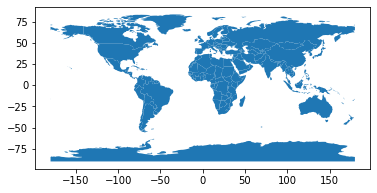

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot()

In [5]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### Data from Canada

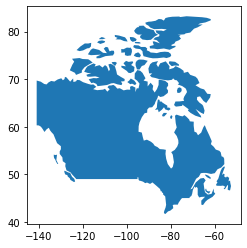

In [6]:
canada = world[world.name == 'Canada']
canada.plot()

### Data from US

In [7]:
import libpysal
us = libpysal.examples.load_example('us_income')

In [8]:
us.get_file_list()

['/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/spi_download.csv',
 '/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/usjoin.csv',
 '/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/states48.gal',
 '/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/README.md',
 '/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/us48.shx',
 '/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/us48.shp',
 '/Users/noraizasif/opt/anaconda3/lib/python3.8/site-packages/libpysal/examples/us_income/us48.dbf']

In [9]:
us = geopandas.read_file(us.get_path("us48.shp"))

In [ ]:
#us.crs = canada.crs
#us = us.to_crs(canada.crs)

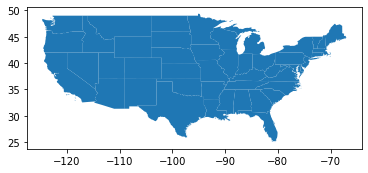

In [10]:
us.plot()

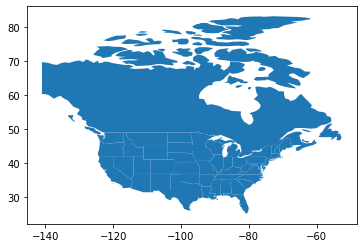

In [11]:
uscanada = us.append(canada) 
uscanada.plot()

In [12]:
# Checking for holes in the entire US-Canada data set
holes = geoplanar.holes(uscanada)
holes.total_bounds

array([-117.81836701,   38.78812027,  -67.74622584,   49.38905   ])

### Subsample of Data for Border

We have appended the Canada gdf to the US gdf. For now, however, we are going to zoom in on a subset of the border region to investigate things further:

In [13]:
from shapely.geometry import box

clipper = geopandas.GeoDataFrame(geometry =[box(-100, 38, -65, 54)])


In [15]:
usborder = geopandas.clip(clipper, us)
canborder = geopandas.clip(clipper, canada)

<ipython-input-15-4b2c016e4abf>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  canborder = geopandas.clip(clipper, canada)


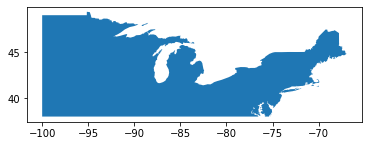

In [16]:
usborder.plot()

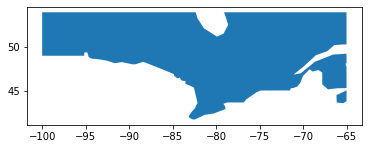

In [17]:
canborder.plot()

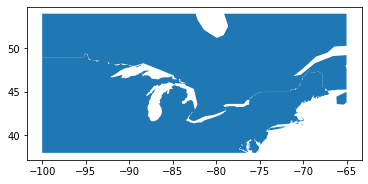

In [18]:
uscan = usborder.append(canborder)
uscan.reset_index(inplace=True)
uscan.plot()

### Checking for Border discrepancies

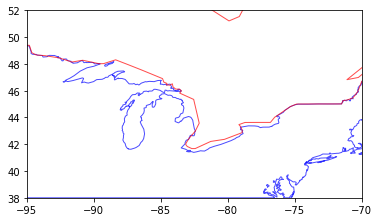

In [19]:
base = usborder.plot(alpha=0.7, facecolor='none', edgecolor='blue')
_ = canborder.plot(alpha=0.7, facecolor='none', edgecolor='red', ax=base)
_ = base.set_xlim(-95, -70)
_ = base.set_ylim(38, 52)


Here we see an example of the kinds of problems that can occur when combining different geospatial datasets that have been constructed by different researchers. 

## Fixing Overlaps/Overshoots

In [20]:
uscan = usborder.append(canborder)
uscan.reset_index(inplace=True)
uscan['COUNTRY'] = ["US", "CANADA"]
uscan.area

0    223.612473
1    258.005041
dtype: float64

In [21]:
# Checking for any overlaps in the combined dataset
geoplanar.is_overlapping(uscan)

True

In [22]:
# 1- Fixing the overlaps using the default
border_overlaps_removed = geoplanar.trim_overlaps(uscan)
border_overlaps_removed.area # here canada gets trimmed

0    223.612473
1    257.762447
dtype: float64

In [23]:
# 2- Fixing the overlaps in data by changing the default setting
border_overlaps_removed_1 = geoplanar.trim_overlaps(uscan, largest=False)
border_overlaps_removed_1.area # here US gets trimmed

0    223.369879
1    258.005041
dtype: float64

In [24]:
geoplanar.is_overlapping(border_overlaps_removed) 
# False tells us that there are no overlaps in the dataset

False

## Fixing undershoots/holes

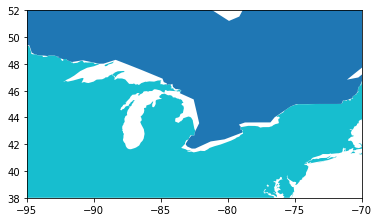

In [26]:
base = border_overlaps_removed.plot(column='COUNTRY')
_ = base.set_xlim(-95, -70)
_ = base.set_ylim(38, 52)


In [30]:
holes_new = geoplanar.holes(border_overlaps_removed)
holes_new.shape

(32, 3)

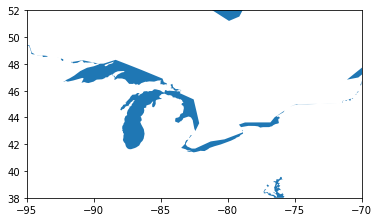

In [28]:
base = holes_new.plot()
_ = base.set_xlim(-95, -70)
_ = base.set_ylim(38, 52)


Note: Some holes might not be the result of data problems instead they can be a consequence of geographic factors such as water bodies as is the case with US- Canada border.

In [31]:
final = geoplanar.fill_holes(border_overlaps_removed)

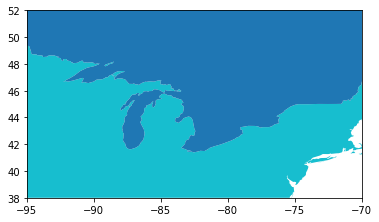

In [32]:
base = final.plot(column='COUNTRY')
_ = base.set_xlim(-95, -70)
_ = base.set_ylim(38, 52)


In [34]:
h1 = geoplanar.holes(final)
h1.shape

(4, 3)

## Changing the defaults

In [35]:
uscan = usborder.append(canborder)
uscan.reset_index(inplace=True)
uscan['COUNTRY'] = ["US", "CANADA"]
uscan.area

0    223.612473
1    258.005041
dtype: float64

In [41]:
border_overlaps_removed_us = geoplanar.trim_overlaps(uscan, largest=False)


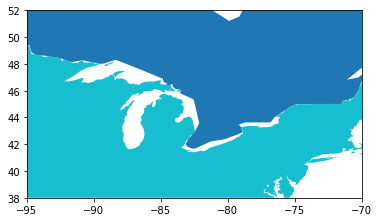

In [42]:
base = border_overlaps_removed_us.plot(column='COUNTRY')
_ = base.set_xlim(-95, -70)
_ = base.set_ylim(38, 52)


In [46]:
final_us = geoplanar.fill_holes(border_overlaps_removed_us, largest=False)

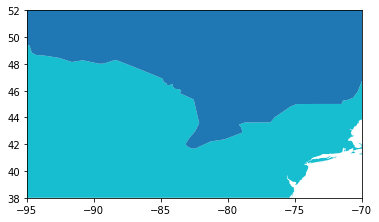

In [47]:
base = final_us.plot(column='COUNTRY')
_ = base.set_xlim(-95, -70)
_ = base.set_ylim(38, 52)


In [48]:
h2 = geoplanar.holes(final_us)
h2.shape

(1, 3)